Analysis for Dataset 1:

- [www.bbci.de/competition/iv/desc_1.html](https://www.bbci.de/competition/iv/desc_1.html)

In [1]:
import os
import numpy as np
import scipy.io as sio
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sklearn.utils.validation
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from pyrcn.echo_state_network import ESNRegressor
from pyrcn.base.blocks import InputToNode, NodeToNode

## Data exploration

In [2]:
BASE_DIR = 'data'
DATA_DIR = os.path.join(BASE_DIR, 'BCICIV_1_mat')
LABELS_DIR = os.path.join(BASE_DIR, 'true_labels')

print(f"Base dir: {BASE_DIR}")
print(f"Signal dir: {DATA_DIR}")
print(f"Labels dir: {LABELS_DIR}")

sub = 'g' # patient a, b, c, d, e, f, g

calib_file = os.path.join(DATA_DIR, f'BCICIV_calib_ds1{sub}.mat')
eval_file = os.path.join(DATA_DIR, f'BCICIV_eval_ds1{sub}.mat')
labels_file = os.path.join(LABELS_DIR, f'BCICIV_eval_ds1{sub}_1000Hz_true_y.mat')

Base dir: data
Signal dir: data/BCICIV_1_mat
Labels dir: data/true_labels


In [3]:
def inspect_mat_file(filepath, description):
    print()
    print(f"[{description}]")
    print(f"Path: {filepath}")
    
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return None

    try:
        mat = sio.loadmat(filepath)
    except Exception as e:
        print(f"Error loading .mat file: {e}")
        return None
    
    keys = [key for key in mat.keys() if not key.startswith('__')]
    print(f"Keys: {keys}")
    
    for key in keys:
        val = mat[key]
        
        # Continuous Signal
        if key == 'cnt':
            print(f" - '{key}': EEG Signal | Samples: {val.shape[0]} | Channels: {val.shape[1]} | Type: {val.dtype}")
        
        # Frequency Info
        elif key == 'nfo':
            try:
                fs = val[0,0]['fs'][0,0]
                classes = val[0,0]['classes']
                print(f" - '{key}': Sampling Rate: {fs} Hz | Classes: {classes}")
            except:
                print(f" - '{key}': Info structure detected")

        # Markers
        elif key == 'mrk':
            try:
                pos = val[0,0]['pos']
                y = val[0,0]['y']
                print(f" - '{key}': Markers | Count: {pos.shape[0] if len(pos.shape)>0 else 0} | Unique classes: {np.unique(y)}")
            except:
                print(f" - '{key}': Marker structure detected")
        
        # True Test Labels
        elif key == 'true_y':
            print(f" - '{key}': True Labels | Shape: {val.shape}")

    return mat


# Calibration Data
mat_calib = inspect_mat_file(calib_file, "Calibration Data")

# # Evaluation Data (Signal)
mat_eval = inspect_mat_file(eval_file, "Evaluation Data")

# # True Test Labels
mat_labels = inspect_mat_file(labels_file, "True Test Labels")


[Calibration Data]
Path: data/BCICIV_1_mat/BCICIV_calib_ds1g.mat
Keys: ['mrk', 'cnt', 'nfo']
 - 'mrk': Markers | Count: 1 | Unique classes: [-1  1]
 - 'cnt': EEG Signal | Samples: 190602 | Channels: 59 | Type: int16
 - 'nfo': Sampling Rate: 100 Hz | Classes: [[array(['left'], dtype='<U4') array(['right'], dtype='<U5')]]

[Evaluation Data]
Path: data/BCICIV_1_mat/BCICIV_eval_ds1g.mat
Keys: ['cnt', 'nfo']
 - 'cnt': EEG Signal | Samples: 243502 | Channels: 59 | Type: int16
 - 'nfo': Sampling Rate: 100 Hz | Classes: [[array(['left'], dtype='<U4') array(['right'], dtype='<U5')]]

[True Test Labels]
Path: data/true_labels/BCICIV_eval_ds1g_1000Hz_true_y.mat
Keys: ['true_y']
 - 'true_y': True Labels | Shape: (2435020, 1)


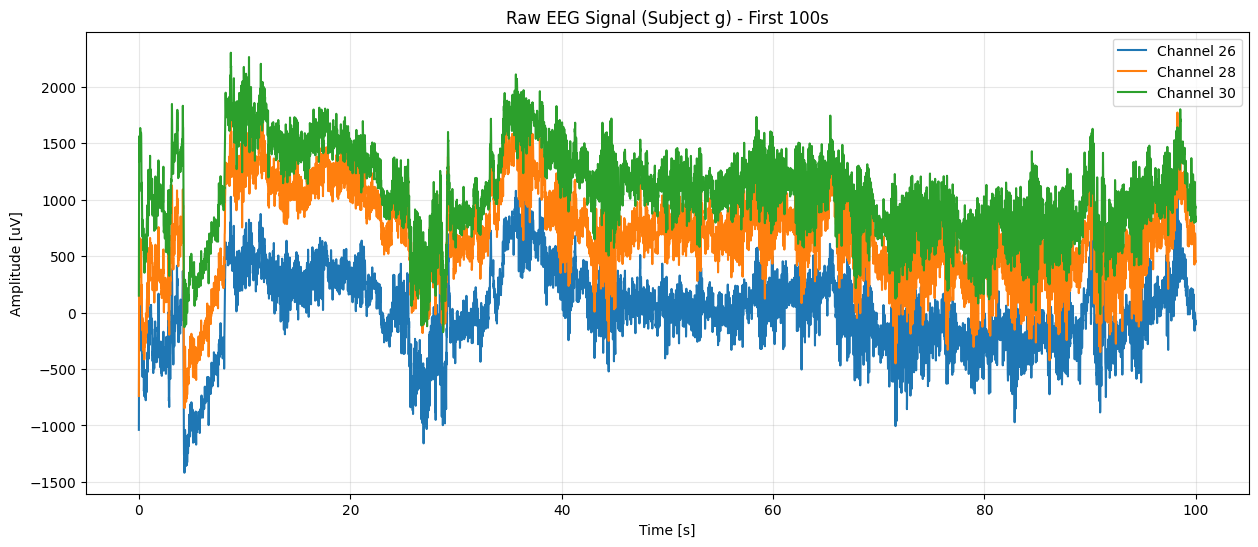

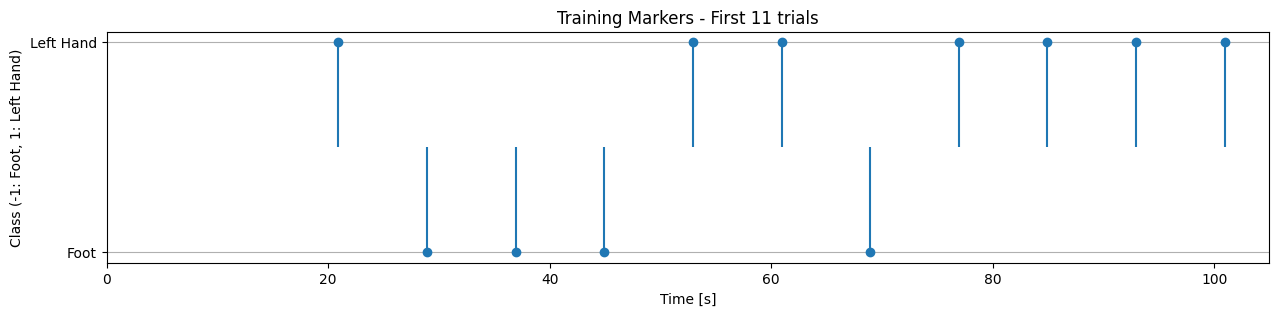

In [4]:
fs = 100  # Sampling frequency 100Hz

# Raw EEG Signal (first n seconds)
channels_to_plot = [26, 28, 30]
duration_sec = 100
samples_to_plot = duration_sec * fs

time_axis = np.arange(samples_to_plot) / fs
plt.figure(figsize=(15, 6))

for i, ch in enumerate(channels_to_plot):
    plt.plot(time_axis, mat_calib['cnt'][:samples_to_plot, ch] - np.mean(mat_calib['cnt'][:, ch]) + i*500, label=f'Channel {ch}')

plt.title(f'Raw EEG Signal (Subject {sub}) - First {duration_sec}s')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [uV]')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

# Training Markers, when the patient was imagining movement
# 'pos' are indices where cues happened
train_pos = mat_calib['mrk'][0,0]['pos'].flatten()
train_y = mat_calib['mrk'][0,0]['y'].flatten()
limit = 11
plt.figure(figsize=(15, 3))
plt.stem(train_pos[:limit] / fs, train_y[:limit], basefmt=" ")
plt.title(f'Training Markers - First {limit} trials')
plt.xlabel('Time [s]')
plt.ylabel('Class (-1: Foot, 1: Left Hand)')
plt.yticks([-1, 1], ['Foot', 'Left Hand'])
plt.grid(True, axis='y')
plt.xlim(0)
plt.show()

## Define data loading and target creation functions


- load_bci_data: Loads .mat files and downsamples labels
- create_continuous_target: Converts markers into continuous time-series signal. Assuming that the movement imagination takes 4 seconds.

In [5]:
def load_bci_data(subject):
    f_calib = os.path.join(DATA_DIR, f'BCICIV_calib_ds1{subject}.mat')
    f_eval = os.path.join(DATA_DIR, f'BCICIV_eval_ds1{subject}.mat')
    f_labels = os.path.join(LABELS_DIR, f'BCICIV_eval_ds1{subject}_1000Hz_true_y.mat')
    
    mat_calib = sio.loadmat(f_calib)
    X_train_raw = mat_calib['cnt'].astype(np.float64) 
    mrk_pos = mat_calib['mrk'][0,0]['pos'].flatten()
    mrk_y = mat_calib['mrk'][0,0]['y'].flatten()
    fs = mat_calib['nfo'][0,0]['fs'][0,0]
    
    mat_eval = sio.loadmat(f_eval)
    X_test_raw = mat_eval['cnt'].astype(np.float64)
    
    mat_labels = sio.loadmat(f_labels)
    y_test_1000hz = mat_labels['true_y'].flatten()
    
    y_test = y_test_1000hz[::10]
    
    min_len = min(len(X_test_raw), len(y_test))
    X_test_raw = X_test_raw[:min_len]
    y_test = y_test[:min_len]
    
    print(f"Subject {subject}: Data loaded.")
    print(f"X_train shape: {X_train_raw.shape}")
    print(f"X_test shape: {X_test_raw.shape}")
    
    return X_train_raw, mrk_pos, mrk_y, X_test_raw, y_test, fs


def create_continuous_target(n_samples, pos, y, fs, duration_sec=4.0):
    target = np.zeros(n_samples)
    duration_samples = int(duration_sec * fs)
    
    for p, label in zip(pos, y):
        end = min(p + duration_samples, n_samples)
        target[p:end] = label
        
    return target

- Continuous target creation - example

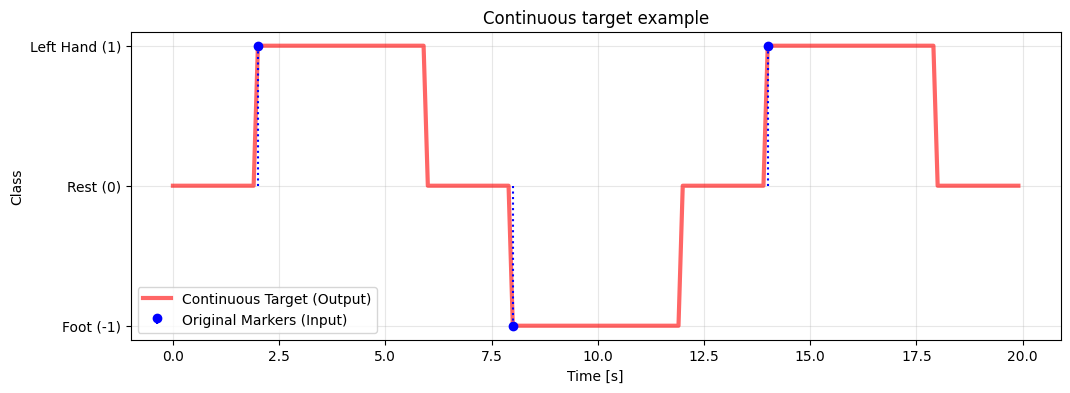

In [6]:
fs_example = 10
duration_total_sec = 20
n_samples_example = duration_total_sec * fs_example
pos_example = np.array([20, 80, 140])
y_example = np.array([1, -1, 1])

target_continuous_example = create_continuous_target(
    n_samples=n_samples_example, 
    pos=pos_example, 
    y=y_example, 
    fs=fs_example, 
    duration_sec=4.0 # assuming that each movement imagination lasts 4 seconds
)

time_axis_example = np.arange(n_samples_example) / fs_example
plt.figure(figsize=(12, 4))
plt.plot(time_axis_example, target_continuous_example, 'r-', linewidth=3, alpha=0.6, label='Continuous Target (Output)')
plt.stem(pos_example / fs_example, y_example, linefmt='b:', markerfmt='bo', basefmt=" ", label='Original Markers (Input)')
plt.title("Continuous target example")
plt.xlabel("Time [s]")
plt.ylabel("Class")
plt.yticks([-1, 0, 1], ['Foot (-1)', 'Rest (0)', 'Left Hand (1)'])
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Define signal processing functions

- preprocess_signal: Bandpass filtering (8-30Hz)
- extract_log_variance_features: Moving window log-variance extraction

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs # Nyquist freq - max possible freq to save when sampling fs (50% of fs according to Shannona theorem)
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')

    # filter coeffs - numerator b and denominator a polynomials
    return b, a


def preprocess_signal(data, lowcut=8.0, highcut=30.0, fs=100.0):
    b, a = butter_bandpass(lowcut, highcut, fs, order=4)
    # Filtering with zero phase shift
    # filtering from left to right, and then from right to left
    y = filtfilt(b, a, data, axis=0)
    return y


def extract_log_variance_features(data, window_size=100):
    # changing volts to energy
    power = np.square(data) # temp energy approx
    window = np.ones(window_size) / window_size
    
    # smoothing energy using moving average to extract power trend
    feat_list = []
    for i in range(data.shape[1]):
        smooth_power = np.convolve(power[:, i], window, mode='same')
        feat_list.append(smooth_power)
        
    features = np.column_stack(feat_list)
    return np.log(features + 1e-6) # converting skewed distr to Gaussian

## Execute data loading and processing pipeline

- Load data for patient (subject)
- Clean NaNs from raw data
- Apply bandpass filter and feature extraction
- Clean NaNs from extracted features

In [8]:
subjects = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
all_X_train_feats = []
all_y_train = []

subject_test_data = {}

for subject in subjects:
    X_train_raw, pos, y_class, X_test_raw, y_test, fs = load_bci_data(subject)

    X_train_raw = np.nan_to_num(X_train_raw, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_raw = np.nan_to_num(X_test_raw, nan=0.0, posinf=0.0, neginf=0.0)

    y_train = create_continuous_target(len(X_train_raw), pos, y_class, fs, duration_sec=4.0)

    X_train_proc = preprocess_signal(X_train_raw, fs=fs)
    X_test_proc = preprocess_signal(X_test_raw, fs=fs)

    X_train_feats = extract_log_variance_features(X_train_proc, window_size=100)
    X_test_feats = extract_log_variance_features(X_test_proc, window_size=100)

    X_train_feats = np.nan_to_num(X_train_feats, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_feats = np.nan_to_num(X_test_feats, nan=0.0, posinf=0.0, neginf=0.0)

    all_X_train_feats.append(X_train_feats)
    all_y_train.append(y_train)

    subject_test_data[subject] = {
        'X_test_feats': X_test_feats,
        'y_test': y_test,
        'fs': fs
    }

X_train_all = np.concatenate(all_X_train_feats)
y_train_all = np.concatenate(all_y_train)

n_features = X_train_all.shape[1]
print(f"Combined input shape: {X_train_all.shape}")

Subject a: Data loaded.
X_train shape: (190594, 59)
X_test shape: (240558, 59)
Subject b: Data loaded.
X_train shape: (190594, 59)
X_test shape: (246970, 59)
Subject c: Data loaded.
X_train shape: (190549, 59)
X_test shape: (233364, 59)
Subject d: Data loaded.
X_train shape: (190473, 59)
X_test shape: (245093, 59)
Subject e: Data loaded.
X_train shape: (190329, 59)
X_test shape: (238450, 59)
Subject f: Data loaded.
X_train shape: (190608, 59)
X_test shape: (239226, 59)
Subject g: Data loaded.
X_train shape: (190602, 59)
X_test shape: (243502, 59)
Combined input shape: (1333749, 59)


## Initialize and Train ESN Model

- Manually generate input weights
- Define ESN layers (Input, Reservoir with leakage, Readout)
- Train the model

In [9]:
hidden_size = 500 # TODO: experiment with bigger hidden size
k_in = 10 

rng = np.random.RandomState(0)
W_in = np.zeros((n_features, hidden_size))

for j in range(hidden_size):
    indices = rng.choice(n_features, k_in, replace=False)
    weights = rng.uniform(-0.1, 0.1, k_in)
    W_in[indices, j] = weights

input_to_node = InputToNode(
    hidden_layer_size=hidden_size,
    input_activation='identity',
    predefined_input_weights=W_in,
    bias_scaling=0.0
)

node_to_node = NodeToNode(
    hidden_layer_size=hidden_size,
    spectral_radius=0.9,
    leakage=0.1,
    reservoir_activation='tanh',
    bidirectional=False
)

regressor = Ridge(alpha=1e-3)

esn = ESNRegressor(
    input_to_node=input_to_node,
    node_to_node=node_to_node,
    regressor=regressor
)

esn.fit(X_train_all, y_train_all)

ESNRegressor(input_to_node=InputToNode(bias_scaling=0.0,
                                       input_activation='identity',
                                       predefined_input_weights=array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.08423152,  0.        , ...,  0.        ,
        -0.07902402,  0.        ],
       [-0.01001   ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.09796325,  0.        ],
       [ 0.        , -0.0833775 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], shape=(59, 500))),
             node_to_node=NodeToNode(leakage=0.1, spectral_radius=0.9),
             regressor=Ridge(alpha=0.001), requires_sequence=False)

## Prediction and Evaluation

In [10]:
y_pred_continuous = esn.predict(X_test_feats)

y_pred_continuous = np.nan_to_num(y_pred_continuous, nan=0.0)
y_test = np.nan_to_num(y_test, nan=0.0)

mse = mean_squared_error(y_test, y_pred_continuous)
print(f"MSE result for subject {subject}: {mse:.4f}")

MSE result for subject g: 0.3624


## Visualizations

- segment of True Labels vs ESN Prediction
- histogram of predicted values

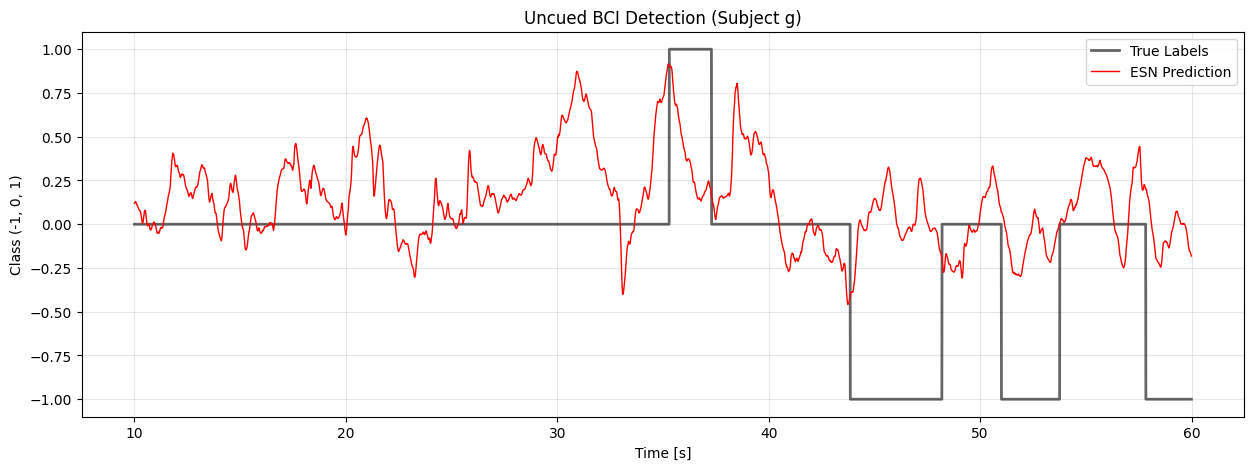

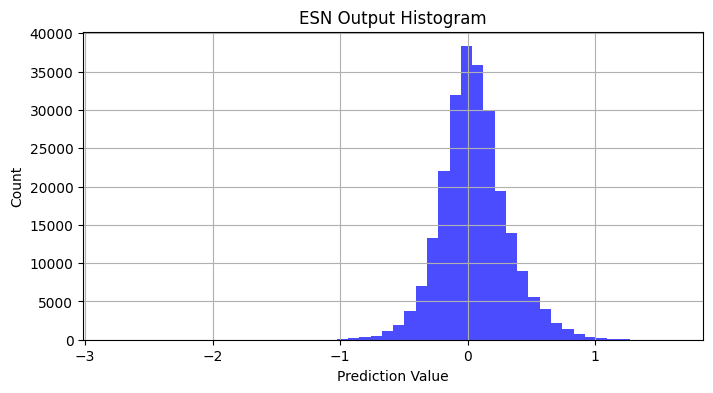

In [11]:
plt.figure(figsize=(15, 5))
samples_to_show = 5000 
start_sample = 1000

t = np.arange(start_sample, start_sample + samples_to_show) / fs

plt.plot(t, y_test[start_sample:start_sample+samples_to_show], 'k-', label='True Labels', linewidth=2, alpha=0.6)
plt.plot(t, y_pred_continuous[start_sample:start_sample+samples_to_show], 'r-', label='ESN Prediction', linewidth=1)

plt.title(f'Uncued BCI Detection (Subject {subject})')
plt.xlabel('Time [s]')
plt.ylabel('Class (-1, 0, 1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(y_pred_continuous, bins=50, color='blue', alpha=0.7)
plt.title('ESN Output Histogram')
plt.xlabel('Prediction Value')
plt.ylabel('Count')
plt.grid(True)
plt.show()

### Show BCI Detection per subject


--- Evaluating Subject a ---
MSE result for subject a: 0.3618


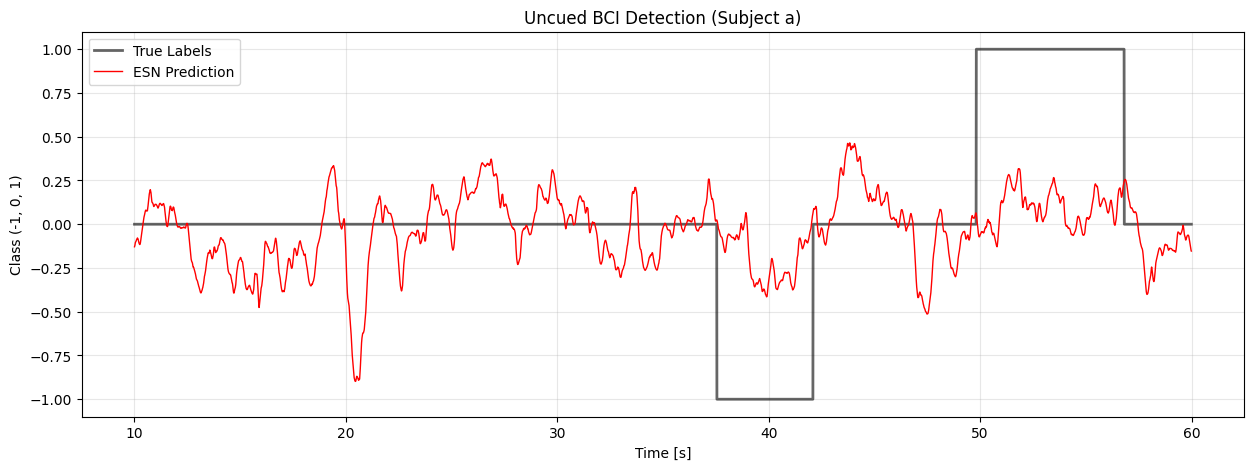

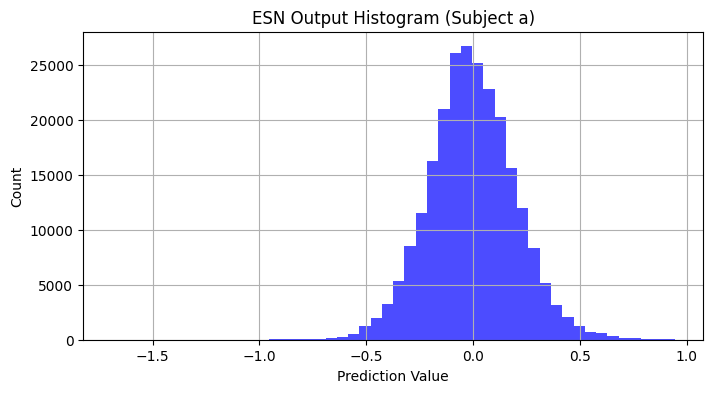


--- Evaluating Subject b ---
MSE result for subject b: 0.4109


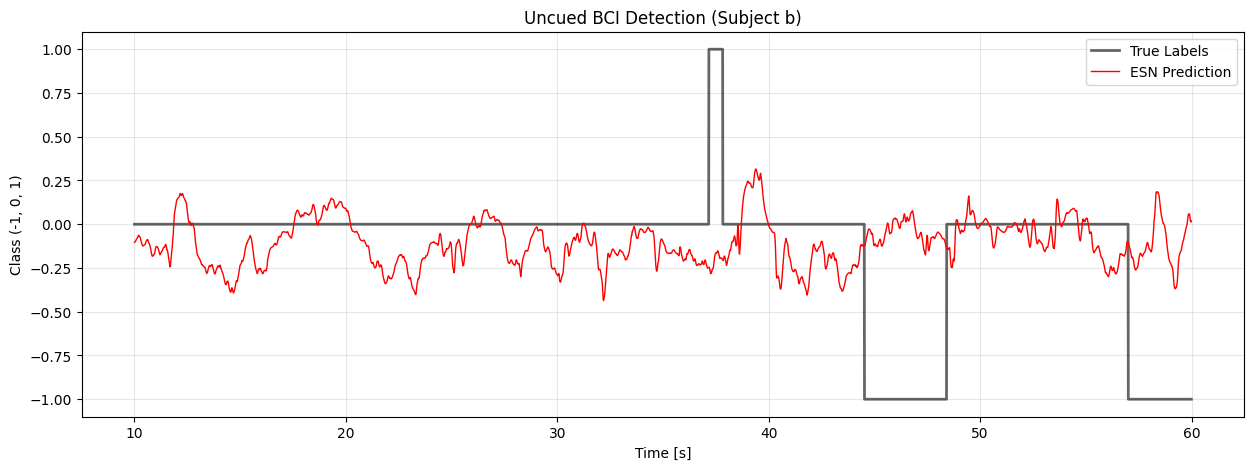

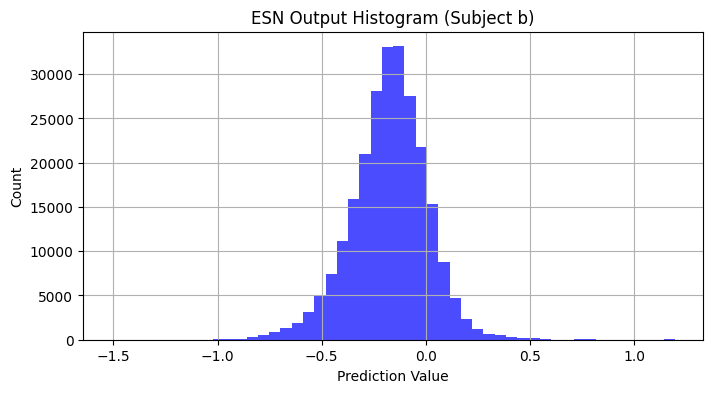


--- Evaluating Subject c ---
MSE result for subject c: 7.3978


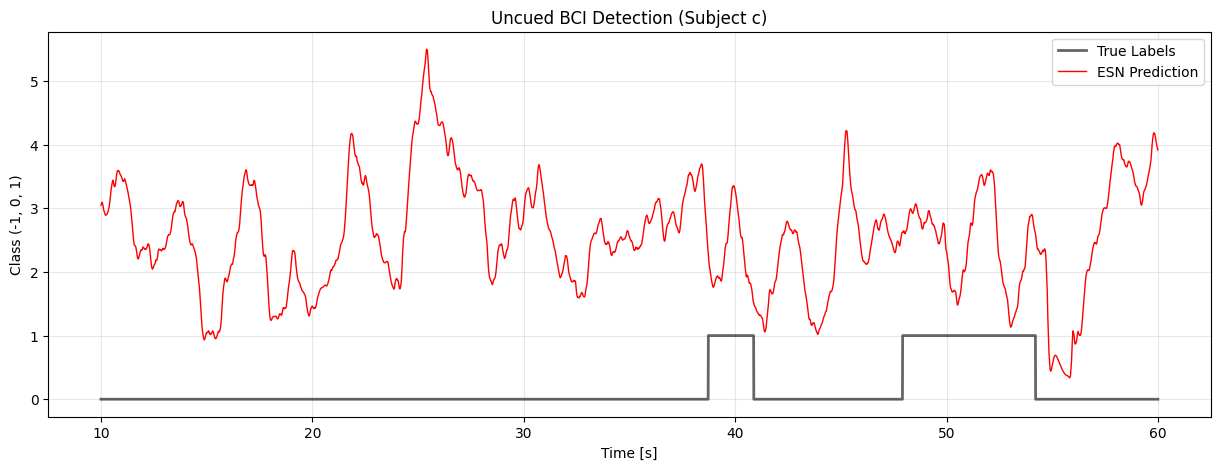

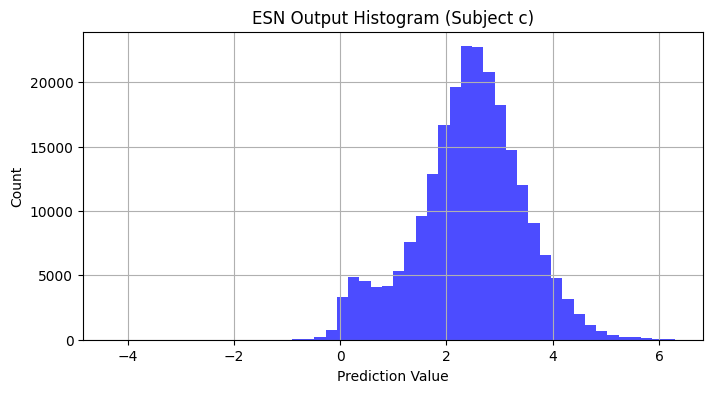


--- Evaluating Subject d ---
MSE result for subject d: 2.4802


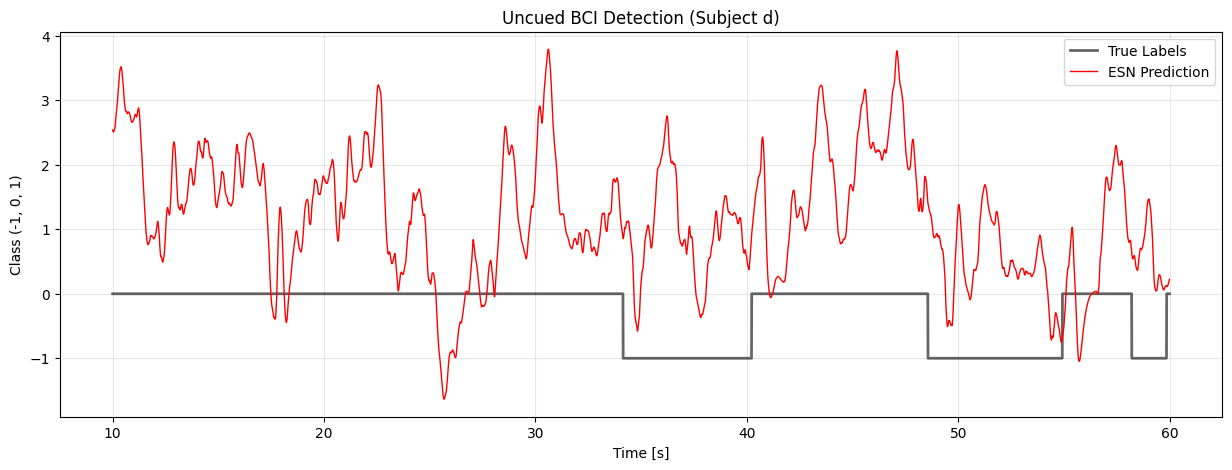

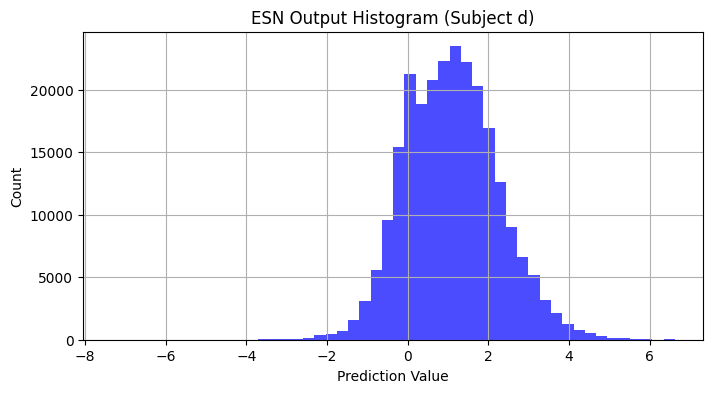


--- Evaluating Subject e ---
MSE result for subject e: 0.3097


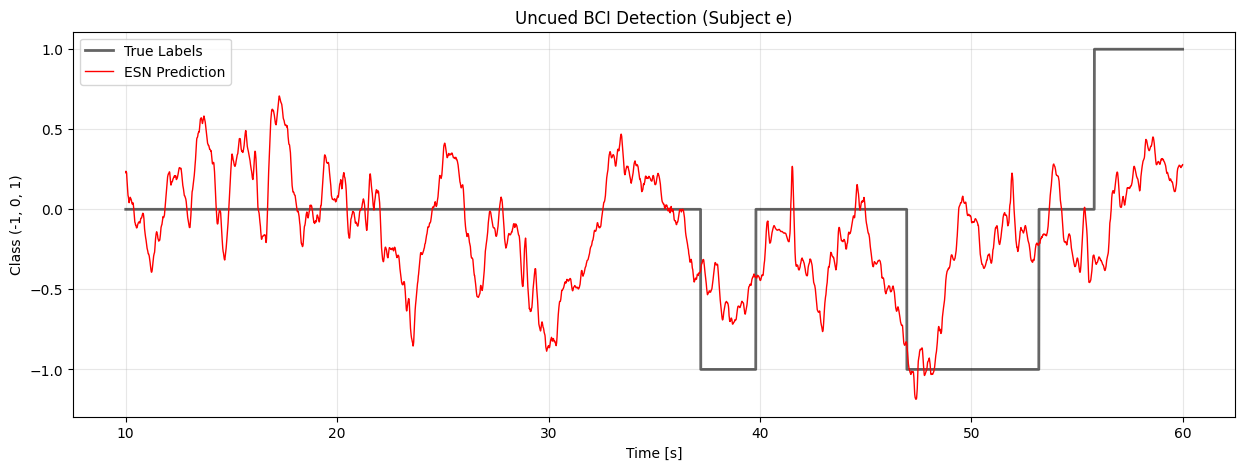

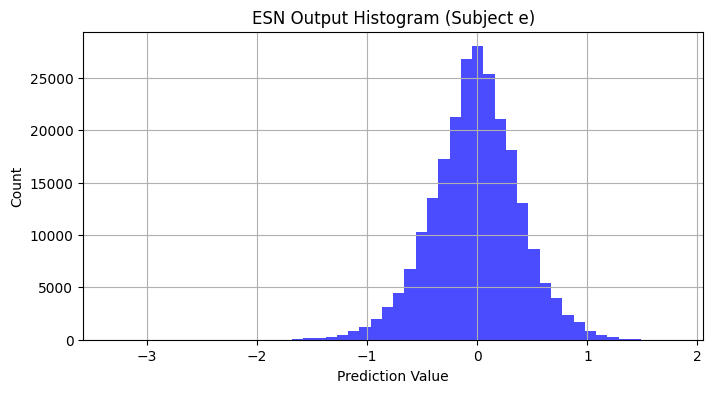


--- Evaluating Subject f ---
MSE result for subject f: 0.3852


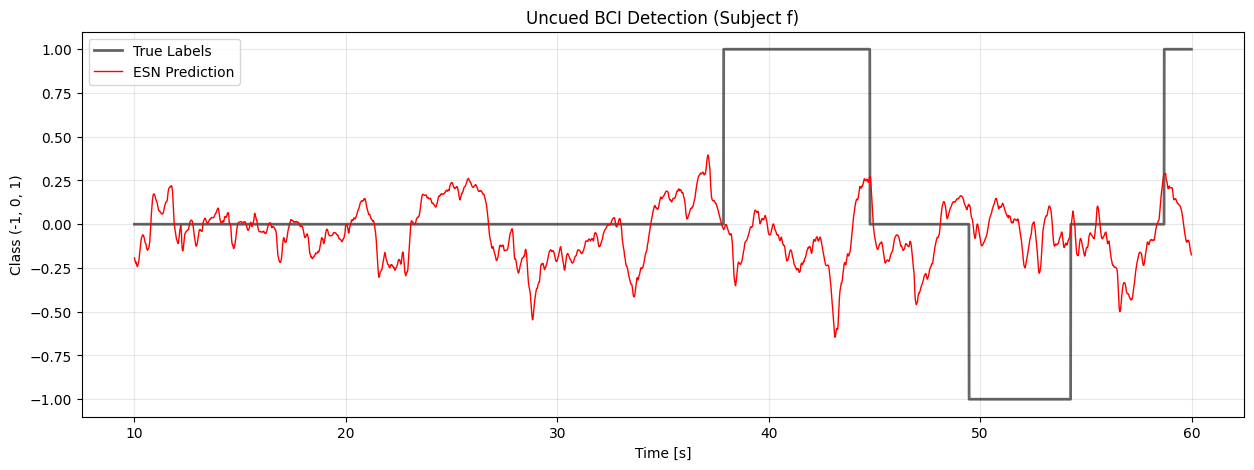

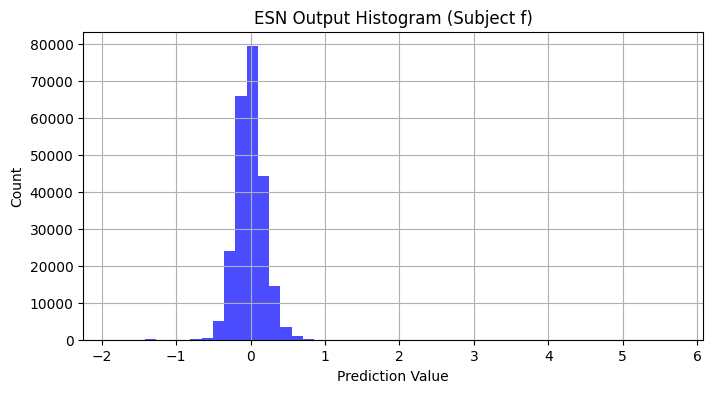


--- Evaluating Subject g ---
MSE result for subject g: 0.3624


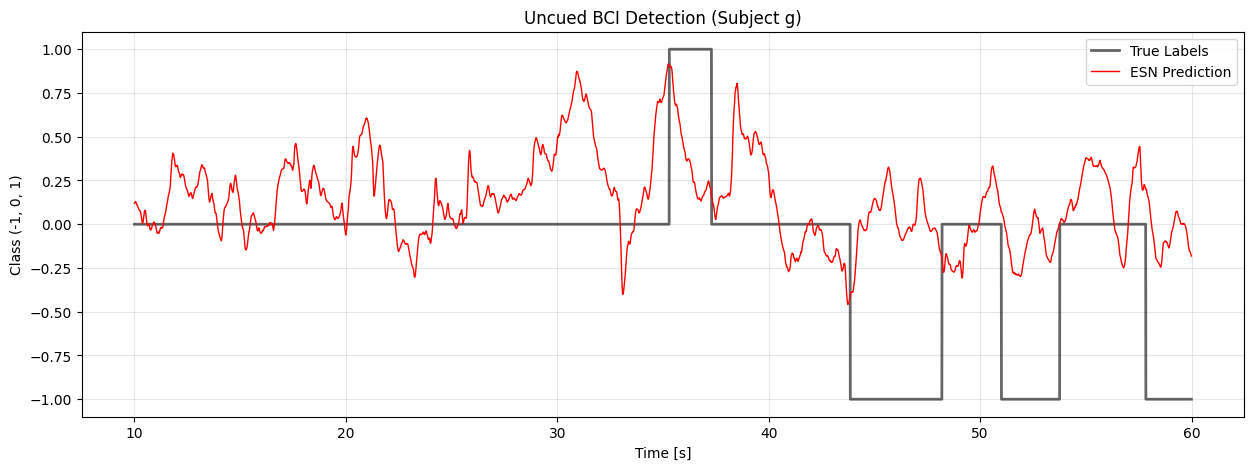

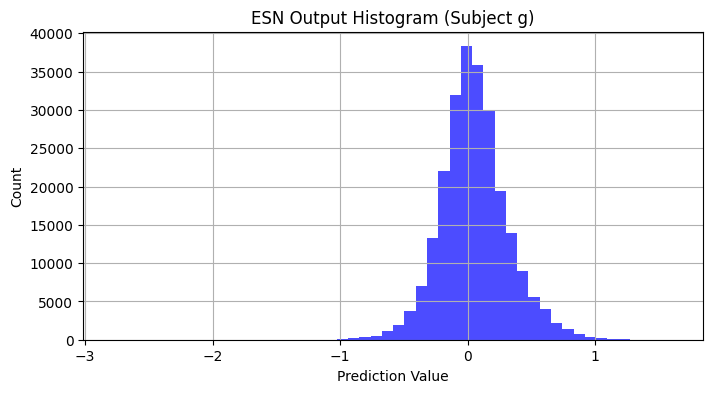

In [12]:
for subject in subjects:
    print(f"\n--- Evaluating Subject {subject} ---")
    
    data = subject_test_data[subject]
    X_test_feats = data['X_test_feats']
    y_test = np.nan_to_num(data['y_test'], nan=0.0)
    fs = data['fs']

    y_pred_continuous = esn.predict(X_test_feats)
    y_pred_continuous = np.nan_to_num(y_pred_continuous, nan=0.0)

    mse = mean_squared_error(y_test, y_pred_continuous)
    print(f"MSE result for subject {subject}: {mse:.4f}")

    plt.figure(figsize=(15, 5))
    samples_to_show = 5000 
    start_sample = 1000
    
    end_sample = min(start_sample + samples_to_show, len(y_test))
    
    if start_sample < end_sample:
        t = np.arange(start_sample, end_sample) / fs
        
        plt.plot(t, y_test[start_sample:end_sample], 'k-', label='True Labels', linewidth=2, alpha=0.6)
        plt.plot(t, y_pred_continuous[start_sample:end_sample], 'r-', label='ESN Prediction', linewidth=1)

        plt.title(f'Uncued BCI Detection (Subject {subject})')
        plt.xlabel('Time [s]')
        plt.ylabel('Class (-1, 0, 1)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print(f"Not enough samples to plot for subject {subject}")

    plt.figure(figsize=(8, 4))
    plt.hist(y_pred_continuous, bins=50, color='blue', alpha=0.7)
    plt.title(f'ESN Output Histogram (Subject {subject})')
    plt.xlabel('Prediction Value')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

## Hyperparameter optimization

In [13]:
import optuna
import numpy as np
import gc
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pyrcn.echo_state_network import ESNRegressor
from pyrcn.base.blocks import InputToNode, NodeToNode
import joblib

STRIDE = 5

# Cast as float32 to ease fitting inside memory
X_full = np.concatenate(all_X_train_feats).astype(np.float32)
y_full = np.concatenate(all_y_train).astype(np.float32)

X_opt_source = X_full[::STRIDE]
y_opt_source = y_full[::STRIDE]

print(f"Full dataset: {X_full.shape}")
print(f"Optuna dataset: {X_opt_source.shape}")

X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_opt_source, y_opt_source, test_size=0.2, random_state=42, shuffle=False
)

n_features = X_train_opt.shape[1]

def objective(trial):
    reservoir_activation = trial.suggest_categorical('reservoir_activation', ['tanh', 'identity'])
    
    if reservoir_activation == 'identity':
        spectral_radius = trial.suggest_float('sr_identity', 0.1, 0.95)
    else:
        spectral_radius = trial.suggest_float('sr_tanh', 0.1, 1.5)

    hidden_size = trial.suggest_int('hidden_size', 200, 2000, step=100)
    k_in = trial.suggest_int('k_in', 1, 20)
    leakage = trial.suggest_float('leakage', 0.01, 1.0)
    bias_scaling = trial.suggest_float('bias_scaling', 0.0, 1.0)
    spectral_radius = trial.suggest_float('spectral_radius', 0.1, 1.5)

    regressor_type = trial.suggest_categorical('regressor', ['Ridge', 'Lasso', 'LinearRegression'])
    
    if regressor_type == 'Ridge':
        alpha = trial.suggest_float('ridge_alpha', 1e-4, 10.0, log=True)
        regressor = Ridge(alpha=alpha)
    elif regressor_type == 'Lasso':
        alpha = trial.suggest_float('lasso_alpha', 1e-4, 1.0, log=True)
        regressor = Lasso(alpha=alpha)
    else:
        regressor = LinearRegression()

    rng = np.random.RandomState(0) 
    W_in = np.zeros((n_features, hidden_size), dtype=np.float32)
    
    for j in range(hidden_size):
        current_k = min(k_in, n_features)
        indices = rng.choice(n_features, current_k, replace=False)
        weights = rng.uniform(-0.1, 0.1, current_k).astype(np.float32)
        W_in[indices, j] = weights

    input_to_node = InputToNode(
        hidden_layer_size=hidden_size,
        input_activation='identity',
        predefined_input_weights=W_in,
        bias_scaling=bias_scaling
    )

    node_to_node = NodeToNode(
        hidden_layer_size=hidden_size,
        spectral_radius=spectral_radius,
        leakage=leakage,
        reservoir_activation=reservoir_activation,
        bidirectional=False
    )

    esn = ESNRegressor(
        input_to_node=input_to_node,
        node_to_node=node_to_node,
        regressor=regressor
    )

    try:
        with joblib.parallel_backend('loky', n_jobs=1):
            esn.fit(X_train_opt, y_train_opt)
            y_pred = esn.predict(X_val_opt)
            
            if np.isnan(y_pred).any():
                raise ValueError("NaNs in prediction")
                
            mse = mean_squared_error(y_val_opt, y_pred)
            
    except Exception as e:
        return float('inf')
    
    finally:
        del esn
        if 'y_pred' in locals(): del y_pred
        gc.collect()

    return mse

if __name__ == "__main__":
    # Minimise MSE
    study = optuna.create_study(direction='minimize')
    
    study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=1)

    print("\n--- Best params found ---")
    print(study.best_params)
    print(f"Best MSE: {study.best_value}")

[I 2025-12-10 18:47:28,135] A new study created in memory with name: no-name-cfc106e6-927b-4244-8571-dec13d749bb5


Full dataset: (1333749, 59)
Optuna dataset: (266750, 59)


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-10 18:47:32,948] Trial 0 finished with value: 0.5261911672316879 and parameters: {'reservoir_activation': 'tanh', 'sr_tanh': 0.5813135739372277, 'hidden_size': 600, 'k_in': 18, 'leakage': 0.3880282876667864, 'bias_scaling': 0.8058878271636112, 'spectral_radius': 1.079358913165103, 'regressor': 'Ridge', 'ridge_alpha': 0.1323978488448862}. Best is trial 0 with value: 0.5261911672316879.
[I 2025-12-10 18:47:35,596] Trial 1 finished with value: 0.42139994325812546 and parameters: {'reservoir_activation': 'tanh', 'sr_tanh': 0.9749857222962933, 'hidden_size': 300, 'k_in': 20, 'leakage': 0.1547621113114657, 'bias_scaling': 0.8198832887101224, 'spectral_radius': 0.15592122150844948, 'regressor': 'Lasso', 'lasso_alpha': 0.12416409936215013}. Best is trial 1 with value: 0.42139994325812546.
[I 2025-12-10 18:48:24,563] Trial 2 finished with value: 0.510158130250566 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.2471951000630299, 'hidden_size': 1400, 'k_in': 13, '

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:175: RuntimeWarning: overflow encountered in multiply
  b = safe_sparse_dot(hidden_layer_state[sample, :],
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[I 2025-12-10 18:49:11,943] Trial 3 finished with value: inf and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.1275378261612369, 'hidden_size': 1500, 'k_in': 14, 'leakage': 0.6857765793622216, 'bias_scaling': 0.6213512239568143, 'spectral_radius': 1.1903668239571052, 'regressor': 'Ridge', 'ridge_alpha': 0.00020807957007290122}. Best is trial 1 with value: 0.42139994325812546.
[I 2025-12-10 18:50:32,418] Trial 4 finished with value: 0.39920005005954673 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.3322648000372514, 'hidden_size': 1600, 'k_in': 15, 'leakage': 0.10682597058435091, 'bias_scaling': 0.4459200924144501, 'spectral_radius': 0.35020524266597053, 'regressor': 'Ridge', 'ridge_alpha': 0.007110255045908381}. Best is trial 4 with value: 0.39920005005954673.
[I 2025-12-10 18:52:59,962] Trial 5 finished with value: 0.42139994325812546 and parameters: {'reservoir_activation': 'tanh', 'sr_tanh': 0.9021539663255401, 'hidden_size': 2000, 'k_in': 

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:175: RuntimeWarning: overflow encountered in multiply
  b = safe_sparse_dot(hidden_layer_state[sample, :],
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[I 2025-12-10 18:53:14,395] Trial 7 finished with value: inf and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.6853958523312363, 'hidden_size': 800, 'k_in': 9, 'leakage': 0.14465759705890952, 'bias_scaling': 0.3549402799229139, 'spectral_radius': 1.3501059480778317, 'regressor': 'Ridge', 'ridge_alpha': 0.09031076104338547}. Best is trial 4 with value: 0.39920005005954673.
[I 2025-12-10 18:55:57,440] Trial 8 finished with value: 0.8897876250195985 and parameters: {'reservoir_activation': 'tanh', 'sr_tanh': 1.4003146180476058, 'hidden_size': 2000, 'k_in': 9, 'leakage': 0.4519205482252151, 'bias_scaling': 0.28817171056024526, 'spectral_radius': 0.7755502336667429, 'regressor': 'LinearRegression'}. Best is trial 4 with value: 0.39920005005954673.
[I 2025-12-10 18:56:06,419] Trial 9 finished with value: 0.4021111192372259 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.5056825568744285, 'hidden_size': 700, 'k_in': 12, 'leakage': 0.19735065478650402,

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:175: RuntimeWarning: overflow encountered in multiply
  b = safe_sparse_dot(hidden_layer_state[sample, :],
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:181: RuntimeWarning: invalid value encountered in add
  (1 - self.leakage) * hidden_layer_state[sample, :] + \
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[I 2025-12-10 19:01:06,425] Trial 18 finished with value: inf and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.533550514068579, 'hidden_size': 500, 'k_in': 6, 'leakage': 0.5778349674658849, 'bias_scaling': 0.7342807428445994, 'spectral_radius': 1.4942135564993944, 'regressor': 'LinearRegression'}. Best is trial 16 with value: 0.39173959676837095.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.924e+04, tolerance: 8.952e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 19:01:40,354] Trial 19 finished with value: 0.3926649925689674 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.7875372255817157, 'hidden_size': 1000, 'k_in': 4, 'leakage': 0.867729056605569, 'bias_scaling': 0.8942493373442413, 'spectral_radius': 0.8562509453899262, 'regressor': 'Lasso', 'lasso_alpha': 0.00014585834343290338}. Best is trial 16 with value: 0.39173959676837095.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:175: RuntimeWarning: overflow encountered in multiply
  b = safe_sparse_dot(hidden_layer_state[sample, :],
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[I 2025-12-10 19:01:41,754] Trial 20 finished with value: inf and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.7982568352286824, 'hidden_size': 200, 'k_in': 7, 'leakage': 0.8798582316873272, 'bias_scaling': 0.7259604925996742, 'spectral_radius': 1.2162263044465962, 'regressor': 'Lasso', 'lasso_alpha': 0.00016754875086151796}. Best is trial 16 with value: 0.39173959676837095.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e+04, tolerance: 8.952e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 19:02:15,744] Trial 21 finished with value: 0.39228664783294687 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.806031532822061, 'hidden_size': 1000, 'k_in': 4, 'leakage': 0.9175403883199402, 'bias_scaling': 0.9161823288932157, 'spectral_radius': 0.8932645981930889, 'regressor': 'Lasso', 'lasso_alpha': 0.00014055083149279085}. Best is trial 16 with value: 0.39173959676837095.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.218e+03, tolerance: 8.952e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 19:03:14,666] Trial 22 finished with value: 0.3948874609855613 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.7997065163829092, 'hidden_size': 1300, 'k_in': 4, 'leakage': 0.8901723322597908, 'bias_scaling': 0.887128293215443, 'spectral_radius': 0.840460387624874, 'regressor': 'Lasso', 'lasso_alpha': 0.00012856672433224643}. Best is trial 16 with value: 0.39173959676837095.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:175: RuntimeWarning: overflow encountered in multiply
  b = safe_sparse_dot(hidden_layer_state[sample, :],
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[I 2025-12-10 19:03:20,408] Trial 23 finished with value: inf and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.606833636373217, 'hidden_size': 900, 'k_in': 3, 'leakage': 0.5602981472327488, 'bias_scaling': 0.908413980763051, 'spectral_radius': 1.124106393545079, 'regressor': 'Lasso', 'lasso_alpha': 0.0015553774320469986}. Best is trial 16 with value: 0.39173959676837095.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.371e+01, tolerance: 8.952e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 19:03:57,175] Trial 24 finished with value: 0.40292753284691996 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.8362365281436062, 'hidden_size': 1000, 'k_in': 8, 'leakage': 0.9112570399531438, 'bias_scaling': 0.7598405492380348, 'spectral_radius': 0.9266124429021722, 'regressor': 'Lasso', 'lasso_alpha': 0.0014944007798264934}. Best is trial 16 with value: 0.39173959676837095.
[I 2025-12-10 19:04:08,609] Trial 25 finished with value: 0.4087566059391068 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.5630376424246261, 'hidden_size': 500, 'k_in': 4, 'leakage': 0.8057675066085443, 'bias_scaling': 0.8704073332136117, 'spectral_radius': 0.8424166766606072, 'regressor': 'Lasso', 'lasso_alpha': 0.001259133582932211}. Best is trial 16 with value: 0.39173959676837095.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.532e+03, tolerance: 8.952e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 19:04:36,690] Trial 26 finished with value: 0.40211430631649514 and parameters: {'reservoir_activation': 'tanh', 'sr_tanh': 0.18933972905398422, 'hidden_size': 800, 'k_in': 7, 'leakage': 0.9945349392033576, 'bias_scaling': 0.9314148902447487, 'spectral_radius': 0.6852798578299655, 'regressor': 'Lasso', 'lasso_alpha': 0.00011008508200637379}. Best is trial 16 with value: 0.39173959676837095.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:175: RuntimeWarning: overflow encountered in multiply
  b = safe_sparse_dot(hidden_layer_state[sample, :],
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:181: RuntimeWarning: invalid value encountered in add
  (1 - self.leakage) * hidden_layer_state[sample, :] + \


[I 2025-12-10 19:04:44,176] Trial 27 finished with value: inf and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.844966339517403, 'hidden_size': 1100, 'k_in': 3, 'leakage': 0.6315377460729057, 'bias_scaling': 0.7889009342110799, 'spectral_radius': 1.2960567207014875, 'regressor': 'Lasso', 'lasso_alpha': 0.0071347430757132645}. Best is trial 16 with value: 0.39173959676837095.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:175: RuntimeWarning: overflow encountered in multiply
  b = safe_sparse_dot(hidden_layer_state[sample, :],
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:181: RuntimeWarning: invalid value encountered in add
  (1 - self.leakage) * hidden_layer_state[sample, :] + \
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[I 2025-12-10 19:04:59,144] Trial 28 finished with value: inf and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.44159931453978113, 'hidden_size': 1300, 'k_in': 11, 'leakage': 0.7748626439946074, 'bias_scaling': 0.6806663319651298, 'spectral_radius': 1.0748049834001752, 'regressor': 'Lasso', 'lasso_alpha': 0.0005654843485944933}. Best is trial 16 with value: 0.39173959676837095.
[I 2025-12-10 19:05:05,177] Trial 29 finished with value: 0.42139994325812546 and parameters: {'reservoir_activation': 'tanh', 'sr_tanh': 1.4805857719172693, 'hidden_size': 800, 'k_in': 5, 'leakage': 0.8803919850053371, 'bias_scaling': 0.5109954619164361, 'spectral_radius': 1.0572992590202324, 'regressor': 'Lasso', 'lasso_alpha': 0.01029692325821011}. Best is trial 16 with value: 0.39173959676837095.
[I 2025-12-10 19:05:12,358] Trial 30 finished with value: 0.39587488628736295 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.7409510516343714, 'hidden_size': 600, 'k_in': 7

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:175: RuntimeWarning: overflow encountered in multiply
  b = safe_sparse_dot(hidden_layer_state[sample, :],
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[I 2025-12-10 19:05:56,300] Trial 34 finished with value: inf and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.7541530959971916, 'hidden_size': 1300, 'k_in': 19, 'leakage': 0.9404395063374269, 'bias_scaling': 0.9305419927024353, 'spectral_radius': 1.1843745895556155, 'regressor': 'Lasso', 'lasso_alpha': 0.0003883403120404716}. Best is trial 16 with value: 0.39173959676837095.
[I 2025-12-10 19:06:03,037] Trial 35 finished with value: 0.3978406815069327 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.673368477031922, 'hidden_size': 900, 'k_in': 6, 'leakage': 0.8527390144130023, 'bias_scaling': 0.8072516988078926, 'spectral_radius': 0.11919953324092192, 'regressor': 'Ridge', 'ridge_alpha': 9.604434644259428}. Best is trial 16 with value: 0.39173959676837095.
[I 2025-12-10 19:06:08,643] Trial 36 finished with value: 0.42139994325812546 and parameters: {'reservoir_activation': 'tanh', 'sr_tanh': 0.11079145186542472, 'hidden_size': 700, 'k_in': 17, 

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:175: RuntimeWarning: overflow encountered in multiply
  b = safe_sparse_dot(hidden_layer_state[sample, :],
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[I 2025-12-10 19:07:25,627] Trial 40 finished with value: inf and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.5906932283738362, 'hidden_size': 700, 'k_in': 8, 'leakage': 0.36776519731714613, 'bias_scaling': 0.7690758924597068, 'spectral_radius': 1.1456803609236976, 'regressor': 'Ridge', 'ridge_alpha': 1.792095885422131}. Best is trial 16 with value: 0.39173959676837095.
[I 2025-12-10 19:07:38,304] Trial 41 finished with value: 0.39327621108684263 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.734382119318616, 'hidden_size': 1200, 'k_in': 5, 'leakage': 0.9459909026357505, 'bias_scaling': 0.9052823530702852, 'spectral_radius': 1.0030756928862399, 'regressor': 'Ridge', 'ridge_alpha': 7.964534376764091}. Best is trial 16 with value: 0.39173959676837095.
[I 2025-12-10 19:08:00,288] Trial 42 finished with value: 0.42140008408651036 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.719503616178743, 'hidden_size': 1000, 'k_in': 5

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:175: RuntimeWarning: overflow encountered in multiply
  b = safe_sparse_dot(hidden_layer_state[sample, :],
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[I 2025-12-10 19:08:37,132] Trial 43 finished with value: inf and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.7850872975439686, 'hidden_size': 1400, 'k_in': 4, 'leakage': 0.8627567758334246, 'bias_scaling': 0.9557631483030194, 'spectral_radius': 1.26119151557128, 'regressor': 'Ridge', 'ridge_alpha': 9.889623509436559}. Best is trial 16 with value: 0.39173959676837095.
[I 2025-12-10 19:08:46,822] Trial 44 finished with value: 0.5089870136146193 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.8817523059669179, 'hidden_size': 1100, 'k_in': 3, 'leakage': 0.01278669150965972, 'bias_scaling': 0.44233342764771, 'spectral_radius': 0.8390015536770261, 'regressor': 'Ridge', 'ridge_alpha': 0.36956942197852644}. Best is trial 16 with value: 0.39173959676837095.
[I 2025-12-10 19:08:54,251] Trial 45 finished with value: 0.39570418164463245 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.14610647852752434, 'hidden_size': 900, 'k_in': 6

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:175: RuntimeWarning: overflow encountered in multiply
  b = safe_sparse_dot(hidden_layer_state[sample, :],
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[I 2025-12-10 19:09:05,022] Trial 46 finished with value: inf and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.3839400690033432, 'hidden_size': 1200, 'k_in': 1, 'leakage': 0.7894696957528673, 'bias_scaling': 0.9652396313223868, 'spectral_radius': 1.0321105695282704, 'regressor': 'Ridge', 'ridge_alpha': 0.03805955998933603}. Best is trial 16 with value: 0.39173959676837095.
[I 2025-12-10 19:11:20,225] Trial 47 finished with value: 0.9171914331791458 and parameters: {'reservoir_activation': 'tanh', 'sr_tanh': 0.5057972169416445, 'hidden_size': 1800, 'k_in': 9, 'leakage': 0.733816144396945, 'bias_scaling': 0.724303553280848, 'spectral_radius': 0.23596437092654643, 'regressor': 'LinearRegression'}. Best is trial 16 with value: 0.39173959676837095.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/pyrcn/base/blocks/_node_to_node.py:175: RuntimeWarning: overflow encountered in multiply
  b = safe_sparse_dot(hidden_layer_state[sample, :],
/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[I 2025-12-10 19:11:27,549] Trial 48 finished with value: inf and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.6887720591337876, 'hidden_size': 1100, 'k_in': 2, 'leakage': 0.9012531173205007, 'bias_scaling': 0.8903352492132253, 'spectral_radius': 1.1232205621777684, 'regressor': 'Ridge', 'ridge_alpha': 0.5331653121873499}. Best is trial 16 with value: 0.39173959676837095.
[I 2025-12-10 19:12:21,077] Trial 49 finished with value: 0.42139994325812546 and parameters: {'reservoir_activation': 'identity', 'sr_identity': 0.6470845620815231, 'hidden_size': 1500, 'k_in': 5, 'leakage': 0.43673515884644276, 'bias_scaling': 0.5829837957799455, 'spectral_radius': 0.7485436227319586, 'regressor': 'Lasso', 'lasso_alpha': 0.022410076046029525}. Best is trial 16 with value: 0.39173959676837095.

--- Best params found ---
{'reservoir_activation': 'identity', 'sr_identity': 0.7020302101985748, 'hidden_size': 1000, 'k_in': 6, 'leakage': 0.9762339695766914, 'bias_scaling': 0.958922865

In [ ]:
bp = study.best_params

if bp['reservoir_activation'] == 'identity':
    final_spectral_radius = bp['sr_identity']
else:
    final_spectral_radius = bp['sr_tanh']

print(f"Wybrana aktywacja: {bp['reservoir_activation']}")
print(f"Wybrany promień spektralny: {final_spectral_radius}")

if bp['regressor'] == 'Ridge':
    final_reg = Ridge(alpha=bp['ridge_alpha'])
elif bp['regressor'] == 'Lasso':
    final_reg = Lasso(alpha=bp['lasso_alpha'])
elif bp['regressor'] == 'ElasticNet':
    final_reg = ElasticNet(alpha=bp['en_alpha'], l1_ratio=bp['en_l1_ratio'])
else:
    final_reg = LinearRegression()
    
rng = np.random.RandomState(0)
final_hidden = bp['hidden_size']
final_k_in = bp['k_in']

W_in_final = np.zeros((n_features, final_hidden), dtype=np.float32)
for j in range(final_hidden):
    curr_k = min(final_k_in, n_features)
    idx = rng.choice(n_features, curr_k, replace=False)
    w = rng.uniform(-0.1, 0.1, curr_k).astype(np.float32)
    W_in_final[idx, j] = w

final_input_to_node = InputToNode(
    hidden_layer_size=final_hidden,
    input_activation='identity',
    predefined_input_weights=W_in_final,
    bias_scaling=bp['bias_scaling']
)

final_node_to_node = NodeToNode(
    hidden_layer_size=final_hidden,
    spectral_radius=final_spectral_radius,
    leakage=bp['leakage'],
    reservoir_activation=bp['reservoir_activation'],
    bidirectional=False
)

final_esn = ESNRegressor(
    input_to_node=final_input_to_node,
    node_to_node=final_node_to_node,
    regressor=final_reg
)

print("Rozpoczynam trening modelu finalnego na pełnych danych...")
final_esn.fit(X_full, y_full)
print("Model finalny gotowy!")

Wybrana aktywacja: identity
Wybrany promień spektralny: 0.7020302101985748
Rozpoczynam trening modelu finalnego na pełnych danych...
Model finalny gotowy!



--- Evaluating Subject a ---
MSE result for subject a: 0.3706


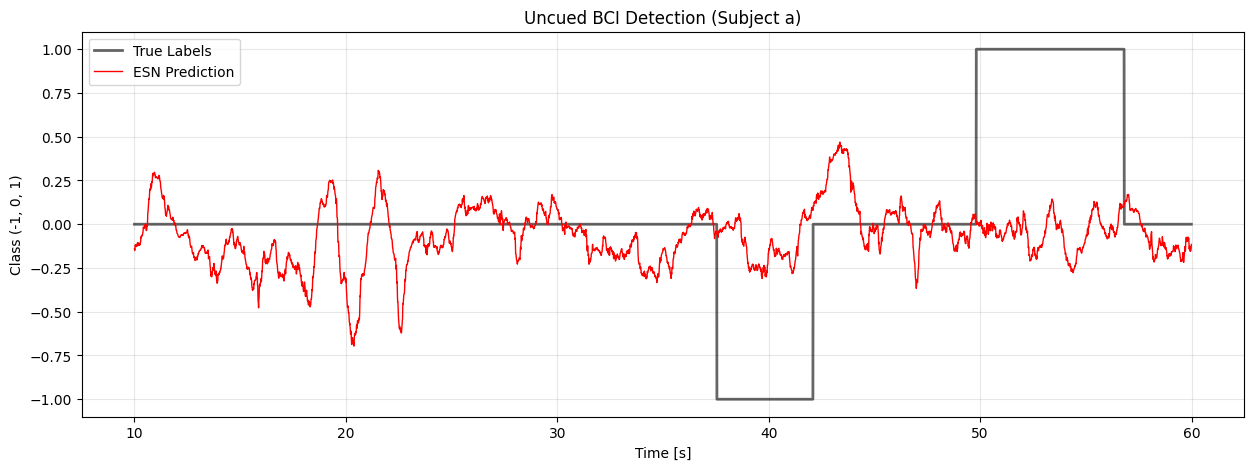

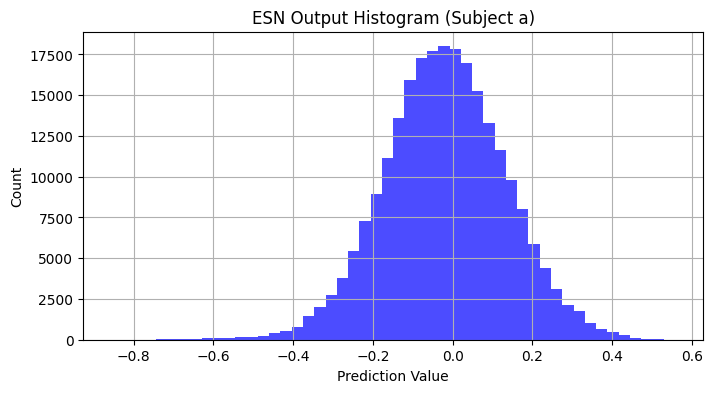


--- Evaluating Subject b ---
MSE result for subject b: 0.3738


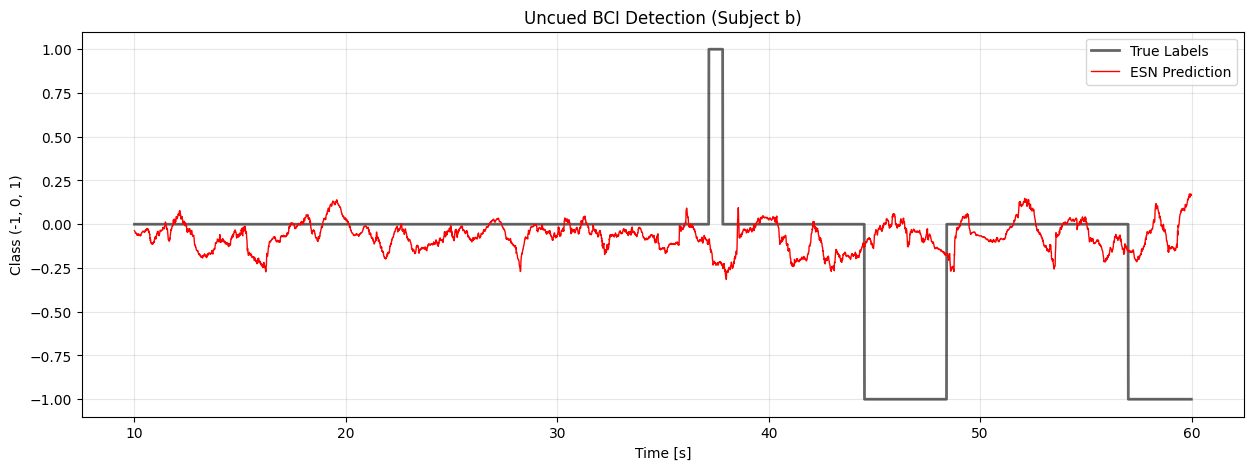

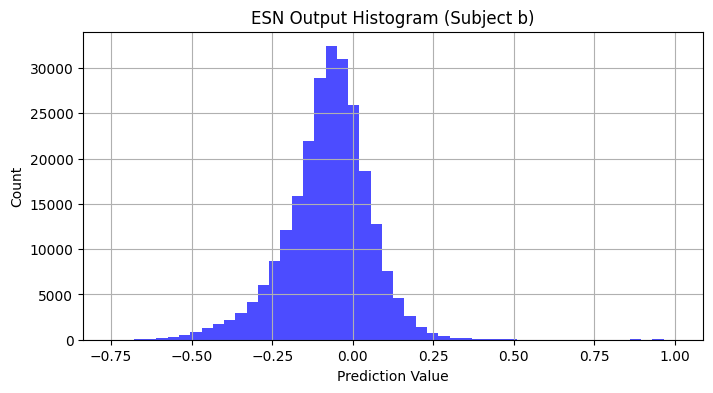


--- Evaluating Subject c ---
MSE result for subject c: 1.7152


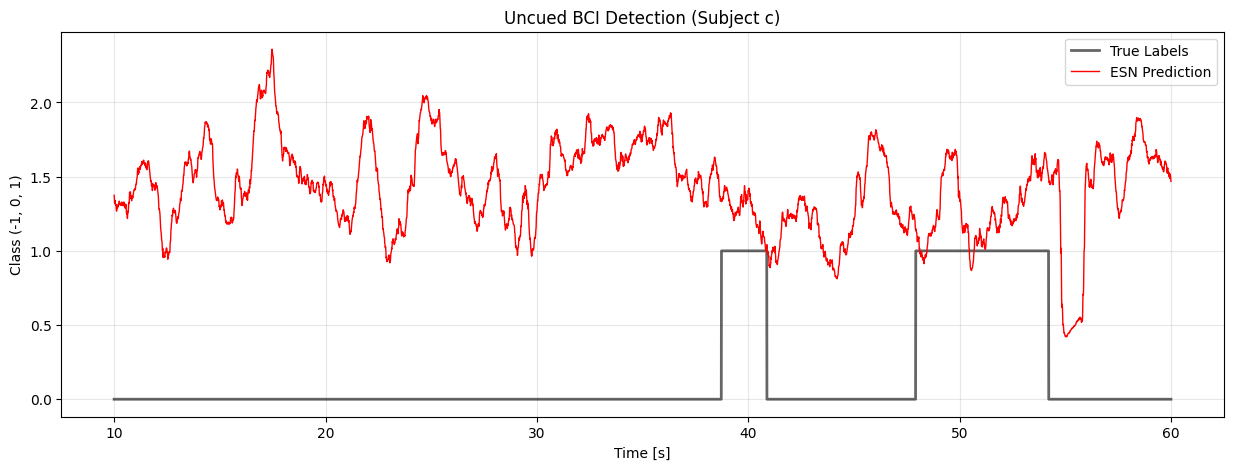

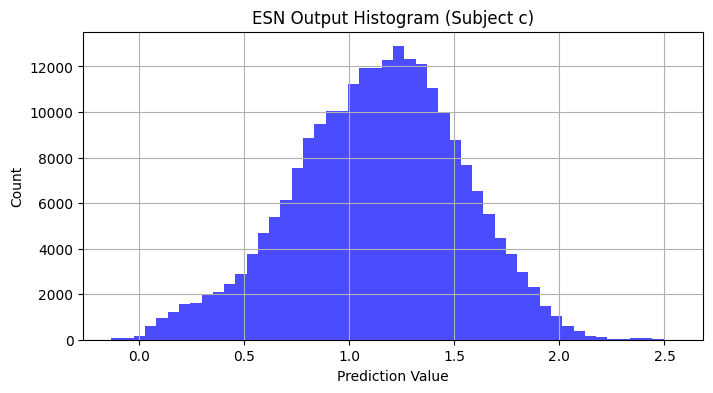


--- Evaluating Subject d ---
MSE result for subject d: 0.5337


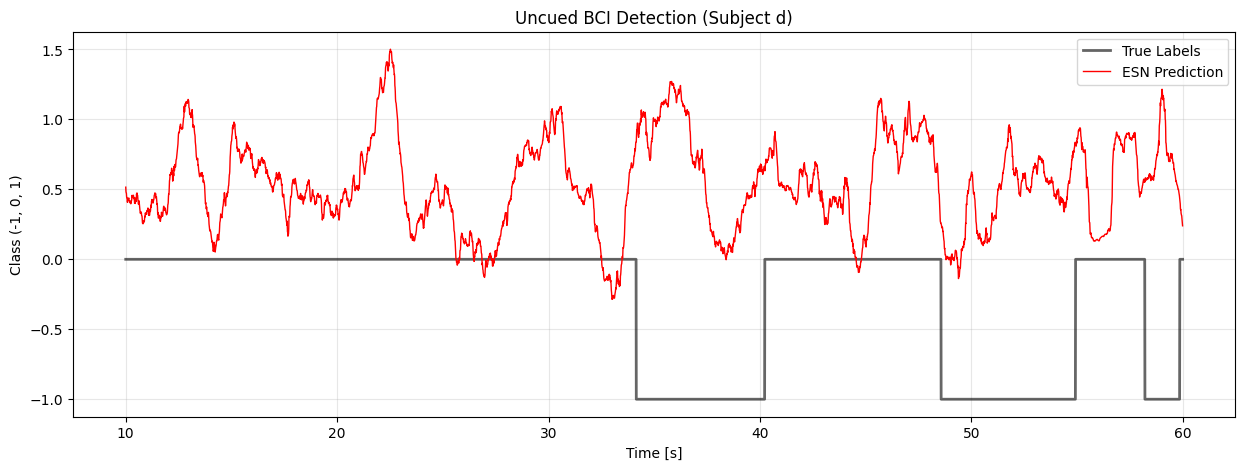

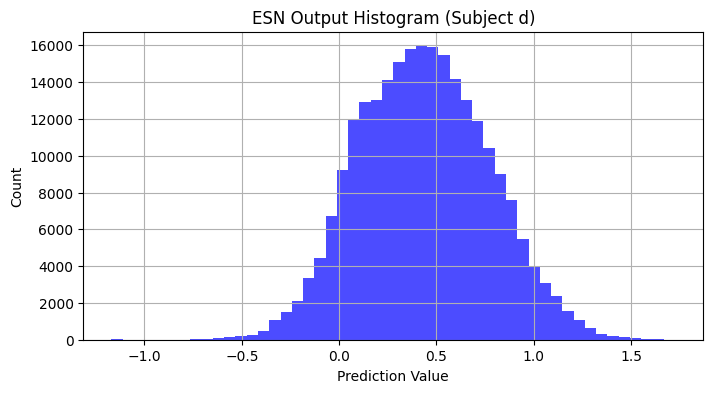


--- Evaluating Subject e ---
MSE result for subject e: 0.3037


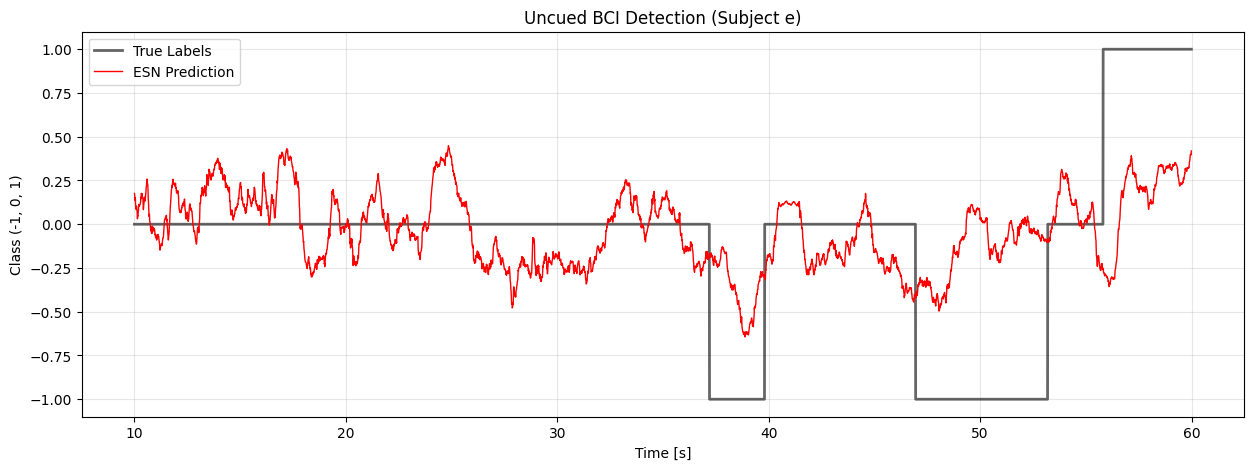

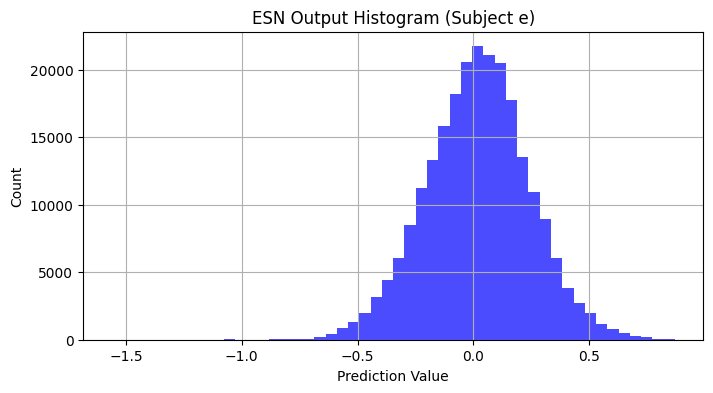


--- Evaluating Subject f ---
MSE result for subject f: 0.3650


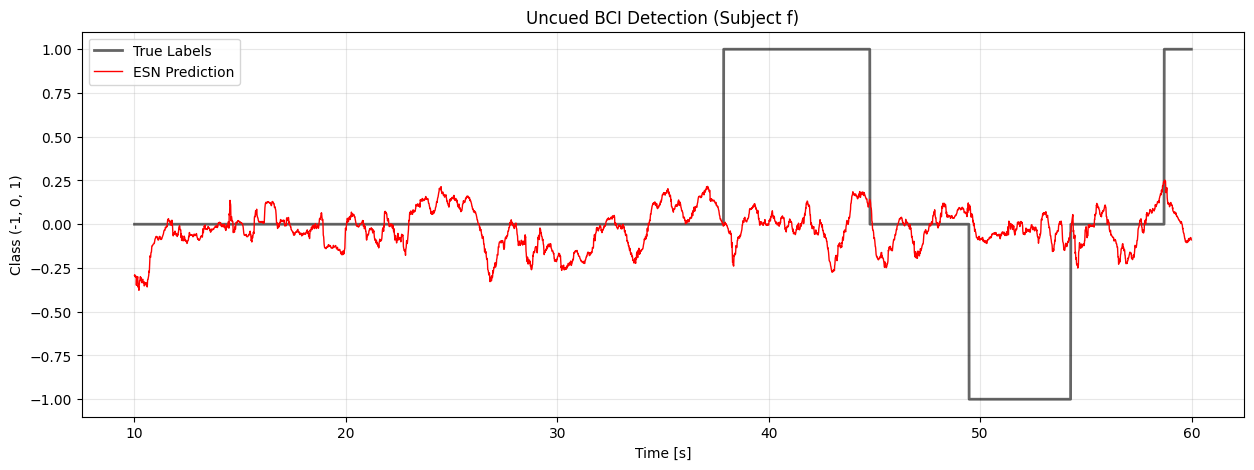

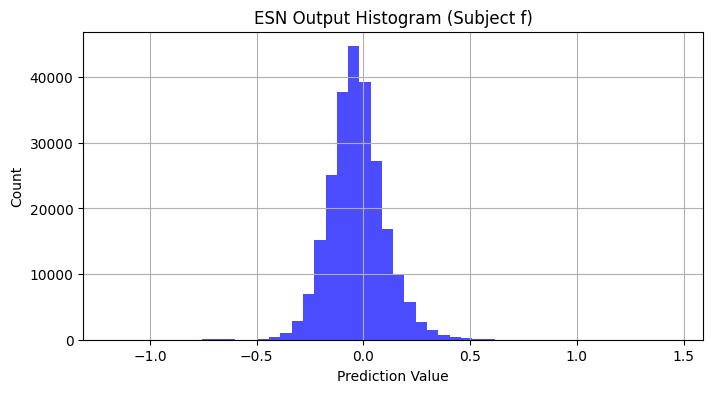


--- Evaluating Subject g ---
MSE result for subject g: 0.3582


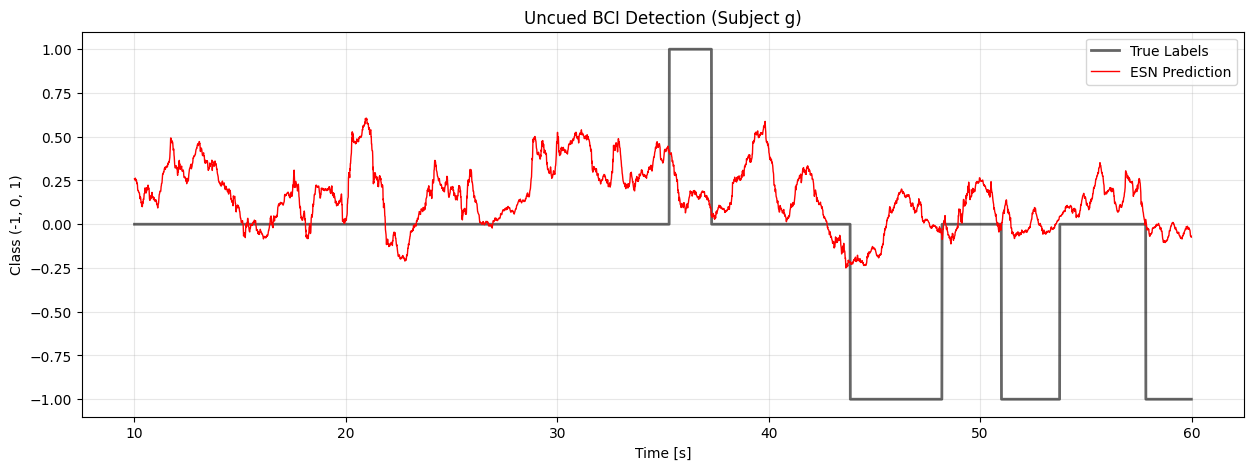

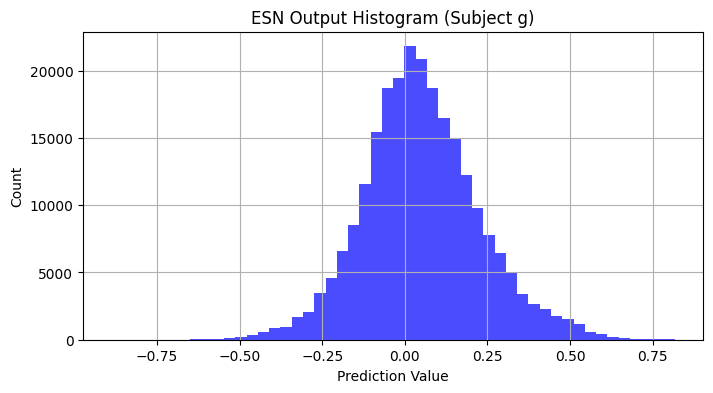

In [15]:
for subject in subjects:
    print(f"\n--- Evaluating Subject {subject} ---")
    
    data = subject_test_data[subject]
    X_test_feats = data['X_test_feats']
    y_test = np.nan_to_num(data['y_test'], nan=0.0)
    fs = data['fs']

    y_pred_continuous = final_esn.predict(X_test_feats)
    y_pred_continuous = np.nan_to_num(y_pred_continuous, nan=0.0)

    mse = mean_squared_error(y_test, y_pred_continuous)
    print(f"MSE result for subject {subject}: {mse:.4f}")

    plt.figure(figsize=(15, 5))
    samples_to_show = 5000 
    start_sample = 1000
    
    end_sample = min(start_sample + samples_to_show, len(y_test))
    
    if start_sample < end_sample:
        t = np.arange(start_sample, end_sample) / fs
        
        plt.plot(t, y_test[start_sample:end_sample], 'k-', label='True Labels', linewidth=2, alpha=0.6)
        plt.plot(t, y_pred_continuous[start_sample:end_sample], 'r-', label='ESN Prediction', linewidth=1)

        plt.title(f'Uncued BCI Detection (Subject {subject})')
        plt.xlabel('Time [s]')
        plt.ylabel('Class (-1, 0, 1)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print(f"Not enough samples to plot for subject {subject}")

    plt.figure(figsize=(8, 4))
    plt.hist(y_pred_continuous, bins=50, color='blue', alpha=0.7)
    plt.title(f'ESN Output Histogram (Subject {subject})')
    plt.xlabel('Prediction Value')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

Summary:

MSE (before and after tuning)
```
a: 0.3618 -> 0.3706
b: 0.4109 -> 0.3738
c: 7.3978 -> 1.7152
d: 2.4802 -> 0.5337
e: 0.3097 -> 0.3037
f: 0.3852 -> 0.3650
g: 0.3624 -> 0.3582
```